# DeepSets performance drop

In [1]:
import bayesflow as bf
import numpy as np

def likelihood(beta, sigma, N):
    # x: predictor variable
    x = np.random.normal(0, 1, size=N)
    # y: response variable
    y = np.random.normal(beta[0] + beta[1] * x, sigma, size=N)
    return dict(y=y, x=x)

def prior():
    # beta: regression coefficients (intercept, slope)
    beta = np.random.normal([2, 0], [3, 1])
    # sigma: residual standard deviation
    sigma = np.random.gamma(1, 1)
    return dict(beta=beta, sigma=sigma)

def meta():
    # N: number of observation in a dataset
    N = np.random.randint(5, 15)
    return dict(N=N)

simulator = bf.simulators.make_simulator([prior, likelihood], meta_fn=meta)

val_sims = simulator.sample(1000)

adapter = (
    bf.Adapter()
    .broadcast("N", to="x")
    .as_set(["x", "y"])
    .constrain("sigma", lower=0)
    .standardize(exclude=["N"])
    .sqrt("N")
    .convert_dtype("float64", "float32")
    .concatenate(["beta", "sigma"], into="inference_variables")
    .concatenate(["x", "y"], into="summary_variables")
    .rename("N", "inference_conditions")
)

2025-05-26 21:04:03.272325: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-26 21:04:03.275194: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-26 21:04:03.283180: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748286243.295866  413460 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748286243.299551  413460 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-26 21:04:03.314883: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
from collections.abc import Sequence

import keras
from keras import ops, layers
from keras.saving import register_keras_serializable as serializable

from bayesflow.types import Tensor
from bayesflow.utils import filter_kwargs, find_pooling
from bayesflow.utils.decorators import sanitize_input_shape

from bayesflow.networks import SummaryNetwork




@serializable(package="bayesflow.networks")
class DeepSetOld(SummaryNetwork):
    """Implements a deep set encoder introduced in [1] for learning permutation-invariant representations of
    set-based data, as generated by exchangeable models.

    [1] Zaheer, M., Kottur, S., Ravanbakhsh, S., Poczos, B., Salakhutdinov, R. R., & Smola, A. J. (2017).
    Deep sets. Advances in neural information processing systems, 30.
    """

    def __init__(
        self,
        summary_dim: int = 16,
        depth: int = 2,
        inner_pooling: str = "mean",
        output_pooling: str = "mean",
        mlp_widths_equivariant: Sequence[int] = (64, 64),
        mlp_widths_invariant_inner: Sequence[int] = (64, 64),
        mlp_widths_invariant_outer: Sequence[int] = (64, 64),
        mlp_widths_invariant_last: Sequence[int] = (64, 64),
        activation: str = "gelu",
        kernel_initializer: str = "he_normal",
        dropout: int | float | None = 0.05,
        spectral_normalization: bool = False,
        **kwargs,
    ):
        """
        Initializes a fully customizable deep learning model for learning permutation-invariant representations of
        sets (i.e., exchangeable or IID data). Do not use this model for non-IID data (e.g., time series).

        Important: Prefer a SetTransformer to a DeepSet, especially is the simulation budget is high.

        The model consists of multiple stacked equivariant transformation modules followed by an invariant pooling
        module to produce a compact set representation.

        The equivariant layers perform many-to-many transformations, preserving structural information, while
        the final invariant module aggregates the set into a lower-dimensional summary.

        The model supports various activation functions, kernel initializations, and optional spectral normalization
        for stability. Pooling mechanisms can be specified for both intermediate and final aggregation steps.

        Parameters
        ----------
        summary_dim : int, optional
            Dimensionality of the final learned summary statistics. Default is 16.
        depth : int, optional
            Number of stacked equivariant modules. Default is 2.
        inner_pooling : str, optional
            Type of pooling operation applied within equivariant modules, such as "mean".
            Default is "mean".
        output_pooling : str, optional
            Type of pooling operation applied in the final invariant module, such as "mean".
            Default is "mean".
        mlp_widths_equivariant : Sequence[int], optional
            Widths of the MLP layers inside the equivariant modules. Default is (64, 64).
        mlp_widths_invariant_inner : Sequence[int], optional
            Widths of the inner MLP layers within the invariant module. Default is (64, 64).
        mlp_widths_invariant_outer : Sequence[int], optional
            Widths of the outer MLP layers within the invariant module. Default is (64, 64).
        mlp_widths_invariant_last : Sequence[int], optional
            Widths of the MLP layers in the final invariant transformation. Default is (64, 64).
        activation : str, optional
            Activation function used throughout the network, such as "gelu". Default is "gelu".
        kernel_initializer : str, optional
            Initialization strategy for kernel weights, such as "he_normal". Default is "he_normal".
        dropout : int, float, or None, optional
            Dropout rate applied within MLP layers. Default is 0.05.
        spectral_normalization : bool, optional
            Whether to apply spectral normalization to stabilize training. Default is False.
        **kwargs
            Additional keyword arguments passed to the equivariant and invariant modules.
        """

        super().__init__(**kwargs)

        # Stack of equivariant modules for a many-to-many learnable transformation
        self.equivariant_modules = []
        for _ in range(depth):
            equivariant_module = EquivariantModule(
                mlp_widths_equivariant=mlp_widths_equivariant,
                mlp_widths_invariant_inner=mlp_widths_invariant_inner,
                mlp_widths_invariant_outer=mlp_widths_invariant_outer,
                activation=activation,
                kernel_initializer=kernel_initializer,
                spectral_normalization=spectral_normalization,
                dropout=dropout,
                pooling=inner_pooling,
                **filter_kwargs(kwargs, EquivariantModule),
            )
            self.equivariant_modules.append(equivariant_module)

        # Invariant module for a many-to-one transformation
        self.invariant_module = InvariantModule(
            mlp_widths_inner=mlp_widths_invariant_last,
            mlp_widths_outer=mlp_widths_invariant_last,
            activation=activation,
            kernel_initializer=kernel_initializer,
            dropout=dropout,
            pooling=output_pooling,
            spectral_normalization=spectral_normalization,
            **filter_kwargs(kwargs, InvariantModule),
        )

        # Output linear layer to project set representation down to "summary_dim" learned summary statistics
        self.output_projector = keras.layers.Dense(summary_dim, activation="linear")
        self.summary_dim = summary_dim

    @sanitize_input_shape
    def build(self, input_shape):
        super().build(input_shape)
        self.call(keras.ops.zeros(input_shape))

    def call(self, x: Tensor, training: bool = False, **kwargs) -> Tensor:
        """
        Performs the forward pass of a hierarchical deep invariant transformation.

        This function applies a sequence of equivariant transformations to the input tensor,
        preserving structural relationships while refining representations. After passing
        through the equivariant modules, the data is processed by an invariant transformation,
        which aggregates information into a lower-dimensional representation. The final output
        is projected to the specified summary dimension using a linear layer.

        Parameters
        ----------
        x : Tensor
            Input tensor representing a set or collection of elements to be transformed.
        training : bool, optional
            Whether the model is in training mode, affecting layers like dropout. Default is False.
        **kwargs
            Additional keyword arguments passed to the transformation layers.

        Returns
        -------
        output : Tensor
            Transformed tensor with a reduced dimensionality, representing the learned summary
            of the input set.
        """

        for em in self.equivariant_modules:
            x = em(x, training=training)

        x = self.invariant_module(x, training=training)

        return self.output_projector(x)


@serializable(package="bayesflow.networks")
class EquivariantModule(keras.Layer):
    """Implements an equivariant module performing an equivariant transform.

    For details and justification, see:

    [1] Bloem-Reddy, B., & Teh, Y. W. (2020). Probabilistic Symmetries and Invariant Neural Networks.
    J. Mach. Learn. Res., 21, 90-1. https://www.jmlr.org/papers/volume21/19-322/19-322.pdf
    """

    def __init__(
        self,
        mlp_widths_equivariant: Sequence[int] = (128, 128),
        mlp_widths_invariant_inner: Sequence[int] = (128, 128),
        mlp_widths_invariant_outer: Sequence[int] = (128, 128),
        pooling: str = "mean",
        activation: str = "gelu",
        kernel_initializer: str = "he_normal",
        dropout: int | float | None = 0.05,
        layer_norm: bool = True,
        spectral_normalization: bool = False,
    ):
        """
        Initializes an equivariant module that combines equivariant transformations with nested invariant transforms
        to enable interactions between set members.

        This module applies an equivariant transformation to each set member, followed by an invariant transformation
        that aggregates information and injects it back into the set representation.

        The architecture consists of a fully connected residual block for equivariant processing and an invariant
        module to enhance expressiveness.

        The model supports different activation functions, dropout, layer normalization, and optional spectral
        normalization for stability.

        Parameters
        ----------
        mlp_widths_equivariant : Sequence[int], optional
            Widths of the MLP layers in the equivariant transformation applied to each set member.
            Default is (128, 128).
        mlp_widths_invariant_inner : Sequence[int], optional
            Widths of the inner MLP layers in the invariant module. Default is (128, 128).
        mlp_widths_invariant_outer : Sequence[int], optional
            Widths of the outer MLP layers in the invariant module. Default is (128, 128).
        pooling : str, optional
            Type of pooling operation used in the invariant module, such as "mean". Default is "mean".
        activation : str, optional
            Activation function applied in the MLP layers, such as "gelu". Default is "gelu".
        kernel_initializer : str, optional
            Initialization strategy for kernel weights, such as "he_normal". Default is "he_normal".
        dropout : int, float, or None, optional
            Dropout rate applied within the MLP layers. Default is 0.05.
        layer_norm : bool, optional
            Whether to apply layer normalization after transformations. Default is True.
        spectral_normalization : bool, optional
            Whether to apply spectral normalization to stabilize training. Default is False.
        """

        super().__init__()

        # Invariant module to increase expressiveness by concatenating outputs to each set member
        self.invariant_module = InvariantModule(
            mlp_widths_inner=mlp_widths_invariant_inner,
            mlp_widths_outer=mlp_widths_invariant_outer,
            activation=activation,
            kernel_initializer=kernel_initializer,
            dropout=dropout,
            pooling=pooling,
            spectral_normalization=spectral_normalization,
        )

        # Fully connected net + residual connection for an equivariant transform applied to each set member
        self.input_projector = layers.Dense(mlp_widths_equivariant[-1])
        self.equivariant_fc = keras.Sequential()
        for width in mlp_widths_equivariant:
            layer = layers.Dense(
                units=width,
                activation=activation,
                kernel_initializer=kernel_initializer,
            )
            if spectral_normalization:
                layer = layers.SpectralNormalization(layer)
            self.equivariant_fc.add(layer)

        self.layer_norm = layers.LayerNormalization() if layer_norm else None

    @sanitize_input_shape
    def build(self, input_shape):
        self.call(keras.ops.zeros(input_shape))

    def call(self, input_set: Tensor, training: bool = False, **kwargs) -> Tensor:
        """Performs the forward pass of a learnable equivariant transform.

        Parameters
        ----------
        input_set : Tensor
            The input tensor representing a set, with shape
            (batch_size, ..., set_size, input_dim).
        training : bool, optional
            A flag indicating whether the model is in training mode. Default is False.
        **kwargs : dict
            Additional keyword arguments for compatibility with other functions.

        Returns
        -------
        Tensor
            The transformed output tensor with the same shape as `input_set`, where
            each element is processed through the equivariant transformation.
        """

        input_set = self.input_projector(input_set)

        # Store shape of input_set, will be (batch_size, ..., set_size, some_dim)
        shape = ops.shape(input_set)

        # Example: Output dim is (batch_size, ..., set_size, representation_dim)
        invariant_summary = self.invariant_module(input_set, training=training)
        invariant_summary = ops.expand_dims(invariant_summary, axis=-2)
        tiler = [1] * len(shape)
        tiler[-2] = shape[-2]
        invariant_summary = ops.tile(invariant_summary, tiler)

        # Concatenate each input entry with the repeated invariant embedding
        output_set = ops.concatenate([input_set, invariant_summary], axis=-1)

        # Pass through final equivariant transform + residual
        output_set = input_set + self.equivariant_fc(output_set, training=training)
        if self.layer_norm is not None:
            output_set = self.layer_norm(output_set, training=training)

        return output_set


@serializable(package="bayesflow.networks")
class InvariantModule(keras.Layer):
    """Implements an invariant module performing a permutation-invariant transform.

    For details and rationale, see:

    [1] Bloem-Reddy, B., & Teh, Y. W. (2020). Probabilistic Symmetries and Invariant Neural Networks.
    J. Mach. Learn. Res., 21, 90-1. https://www.jmlr.org/papers/volume21/19-322/19-322.pdf
    """

    def __init__(
        self,
        mlp_widths_inner: Sequence[int] = (128, 128),
        mlp_widths_outer: Sequence[int] = (128, 128),
        activation: str = "gelu",
        kernel_initializer: str = "he_normal",
        dropout: int | float | None = 0.05,
        pooling: str = "mean",
        pooling_kwargs: dict = None,
        spectral_normalization: bool = False,
    ):
        """
        Initializes an invariant module representing a learnable permutation-invariant function with an option for
        learnable pooling.

        This module applies a two-stage transformation: an inner fully connected network processes individual
        set elements, followed by a pooling operation that aggregates features across the set. The pooled features are
        then passed through an outer fully connected network to produce the final invariant representation.

        The model supports different activation functions, dropout, and optional spectral normalization for stability.
        The pooling mechanism can be customized with additional arguments.

        Parameters
        ----------
        mlp_widths_inner : Sequence[int], optional
            Widths of the MLP layers applied before pooling. Default is (128, 128).
        mlp_widths_outer : Sequence[int], optional
            Widths of the MLP layers applied after pooling. Default is (128, 128).
        activation : str, optional
            Activation function applied in the MLP layers, such as "gelu". Default is "gelu".
        kernel_initializer : str, optional
            Initialization strategy for kernel weights, such as "he_normal". Default is "he_normal".
        dropout : int, float, or None, optional
            Dropout rate applied in the outer MLP layers. Default is 0.05.
        pooling : str, optional
            Type of pooling operation applied across set elements, such as "mean". Default is "mean".
        pooling_kwargs : dict, optional
            Additional keyword arguments for the pooling layer. Default is None.
        spectral_normalization : bool, optional
            Whether to apply spectral normalization to stabilize training. Default is False.
        """

        super().__init__()

        # Inner fully connected net for sum decomposition: inner( pooling( inner(set) ) )
        self.inner_fc = keras.Sequential()
        for width in mlp_widths_inner:
            layer = layers.Dense(
                units=width,
                activation=activation,
                kernel_initializer=kernel_initializer,
            )
            if spectral_normalization:
                layer = layers.SpectralNormalization(layer)
            self.inner_fc.add(layer)

        # Outer fully connected net for sum decomposition: inner( pooling( inner(set) ) )
        self.outer_fc = keras.Sequential()
        for width in mlp_widths_outer:
            if dropout is not None and dropout > 0:
                self.outer_fc.add(layers.Dropout(float(dropout)))

            layer = layers.Dense(
                units=width,
                activation=activation,
                kernel_initializer=kernel_initializer,
            )
            if spectral_normalization:
                layer = layers.SpectralNormalization(layer)
            self.outer_fc.add(layer)

        # Pooling function as keras layer for sum decomposition: inner( pooling( inner(set) ) )
        if pooling_kwargs is None:
            pooling_kwargs = {}

        self.pooling_layer = find_pooling(pooling, **pooling_kwargs)

    @sanitize_input_shape
    def build(self, input_shape):
        self.call(keras.ops.zeros(input_shape))

    def call(self, input_set: Tensor, training: bool = False, **kwargs) -> Tensor:
        """Performs the forward pass of a learnable invariant transform.

        Parameters
        ----------
        input_set : Tensor
            Input of shape (batch_size,..., input_dim)
        training  : bool, optional, default - False
            Dictates the behavior of the optional dropout layers

        Returns
        -------
        set_summary : tf.Tensor
            Output of shape (batch_size,..., out_dim)
        """

        set_summary = self.inner_fc(input_set, training=training)
        set_summary = self.pooling_layer(set_summary, training=training)
        set_summary = self.outer_fc(set_summary, training=training)
        return set_summary

# DeepSet

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/5
200/200 - 23s - 117ms/step - loss: 2.6250 - loss/inference_loss: 2.6250 - val_loss: 2.5807 - val_loss/inference_loss: 2.5807
Epoch 2/5
200/200 - 4s - 20ms/step - loss: 2.3596 - loss/inference_loss: 2.3596 - val_loss: 1.3859 - val_loss/inference_loss: 1.3859
Epoch 3/5
200/200 - 4s - 20ms/step - loss: 1.0469 - loss/inference_loss: 1.0469 - val_loss: 0.8848 - val_loss/inference_loss: 0.8848
Epoch 4/5
200/200 - 4s - 20ms/step - loss: 0.8777 - loss/inference_loss: 0.8777 - val_loss: 1.2589 - val_loss/inference_loss: 1.2589
Epoch 5/5
200/200 - 4s - 22ms/step - loss: 1.8438 - loss/inference_loss: 1.8438 - val_loss: 0.9374 - val_loss/inference_loss: 0.9374


INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/5
200/200 - 20s - 102ms/step - loss: 1.7485 - loss/inference_loss: 1.7485 - val_loss: 1.1475 - val_loss/inference_loss: 1.1475
Epoch 2/5
200/200 - 3s - 16ms/step - loss: 1.0909 - loss/inference_loss: 1.0909 - val_loss: 0.7596 - val_loss/inference_loss: 0.7596
Epoch 3/5
200/200 - 3s - 16ms/step - loss: 0.9101 - loss/inference_loss: 0.9101 - val_loss: 0.3705 - val_loss/inference_loss: 0.3705
Epoch 4/5
200/200 - 3s - 16ms/step - loss: 0.7365 - loss/inference_loss: 0.7365 - val_loss: 0.4307 - val_loss/inference_loss: 0.4307
Epoch 5/5
200/200 - 3s - 16ms/step - loss: 0.5708 - loss/inference_loss: 0.5708 - val_loss: 0.1510 - val_loss/inference_loss: 0.1510


INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/5
200/200 - 28s - 140ms/step - loss: 0.7079 - loss/inference_loss: 0.7079 - val_loss: 0.6004 - val_loss/inference_loss: 0.6004
Epoch 2/5
200/200 - 7s - 35ms/step - loss: 0.2991 - loss/inference_loss: 0.2991 - val_loss: 0.3020 - val_loss/inference_loss: 0.3020
Epoch 3/5
200/200 - 7s - 35ms/step - loss: 0.4281 - loss/inference_loss: 0.4281 - val_loss: -5.0273e-01 - val_loss/inference_loss: -5.0273e-01
Epoch 4/5
200/200 - 7s - 35ms/step - loss: -2.0297e-01 - loss/inference_loss: -2.0297e-01 - val_loss: -7.8808e-01 - val_loss/inference_loss: -7.8808e-01
Epoch 5/5
200/200 - 7s - 36ms/step - loss: -6.6225e-01 - loss/inference_loss: -6.6225e-01 - val_loss: -7.7803e-01 - val_loss/inference_loss: -7.7803e-01


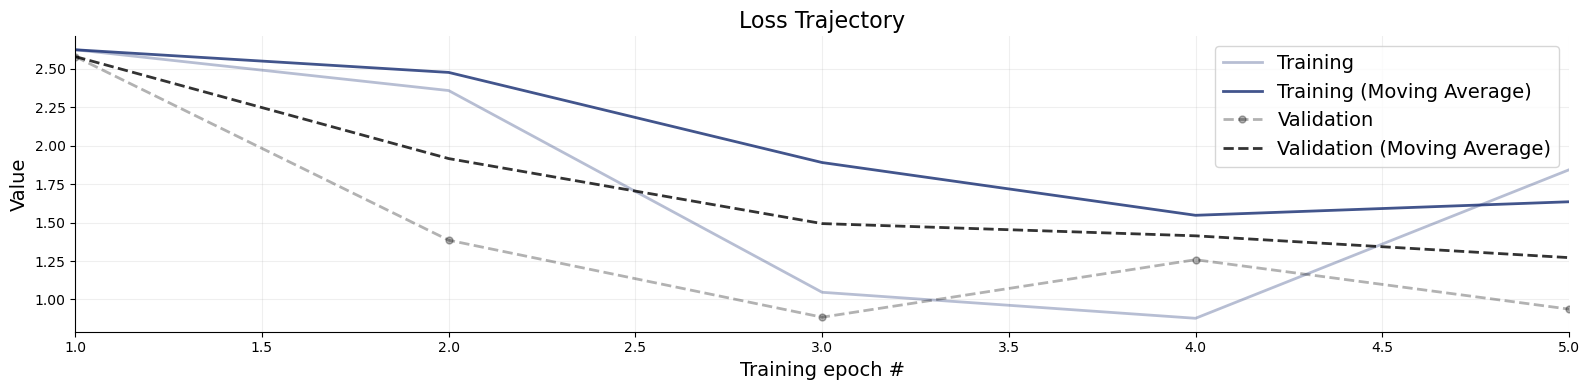

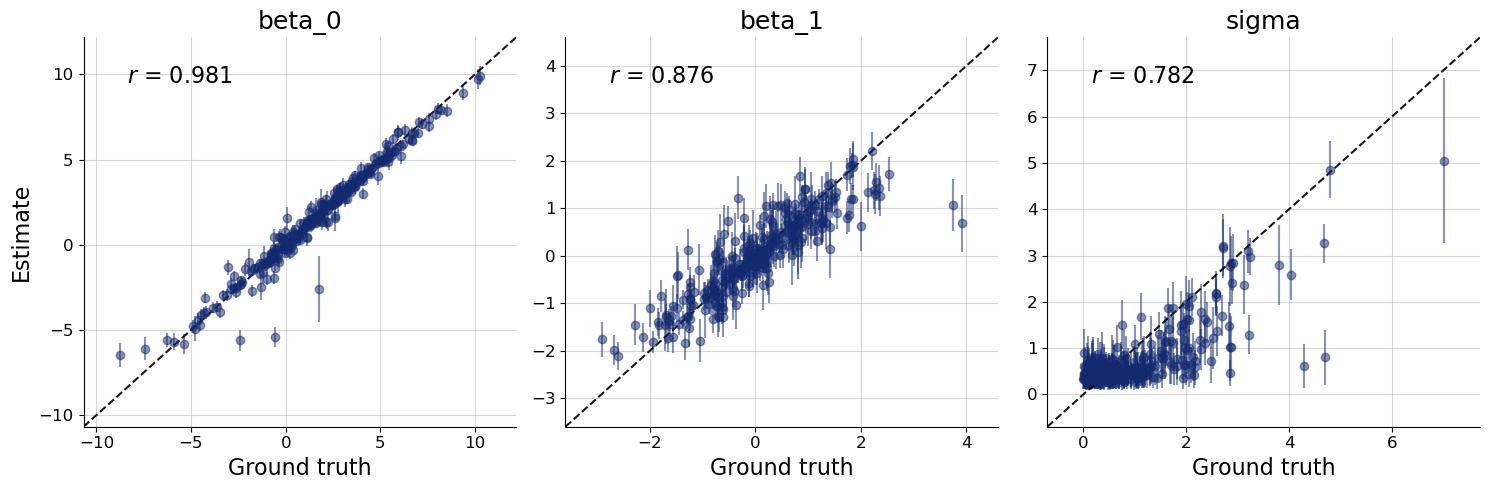

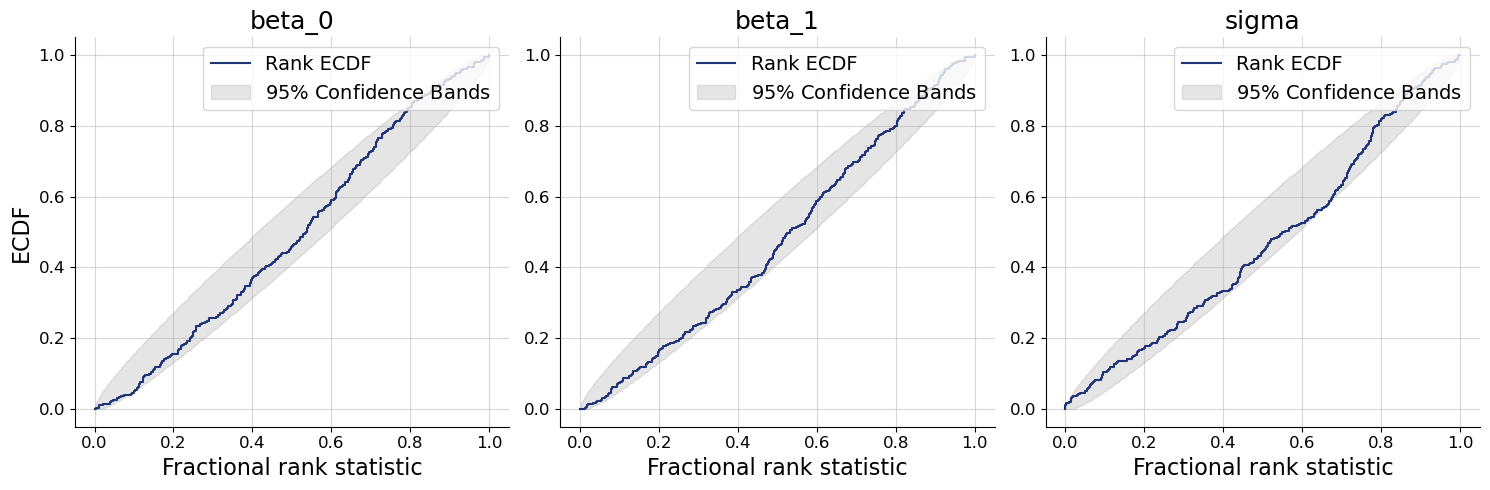

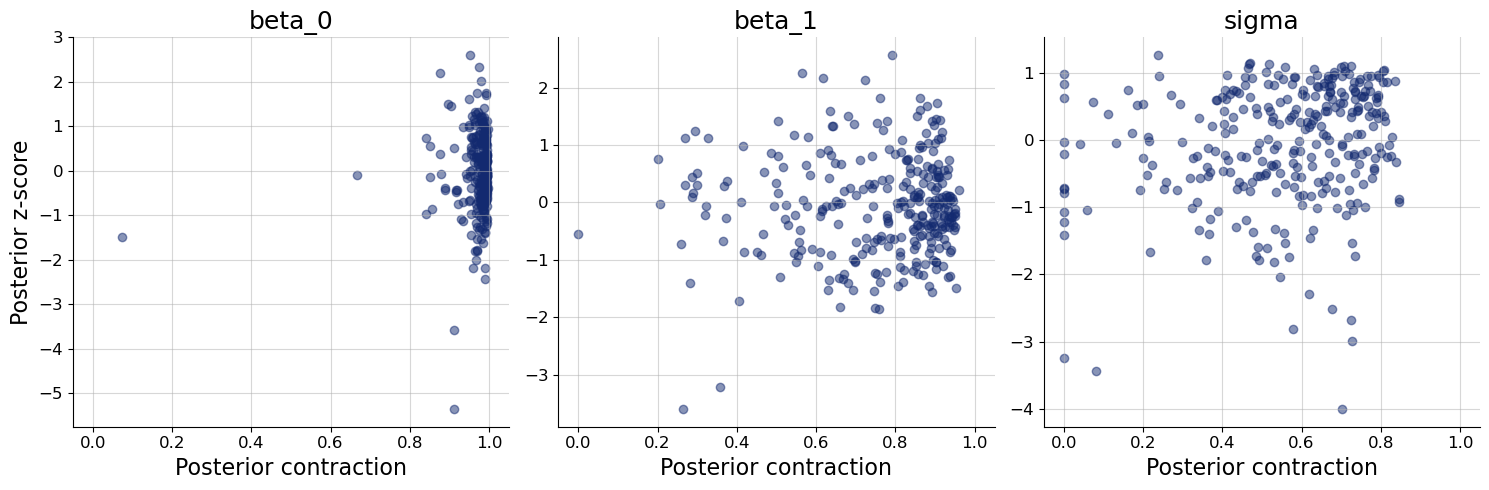

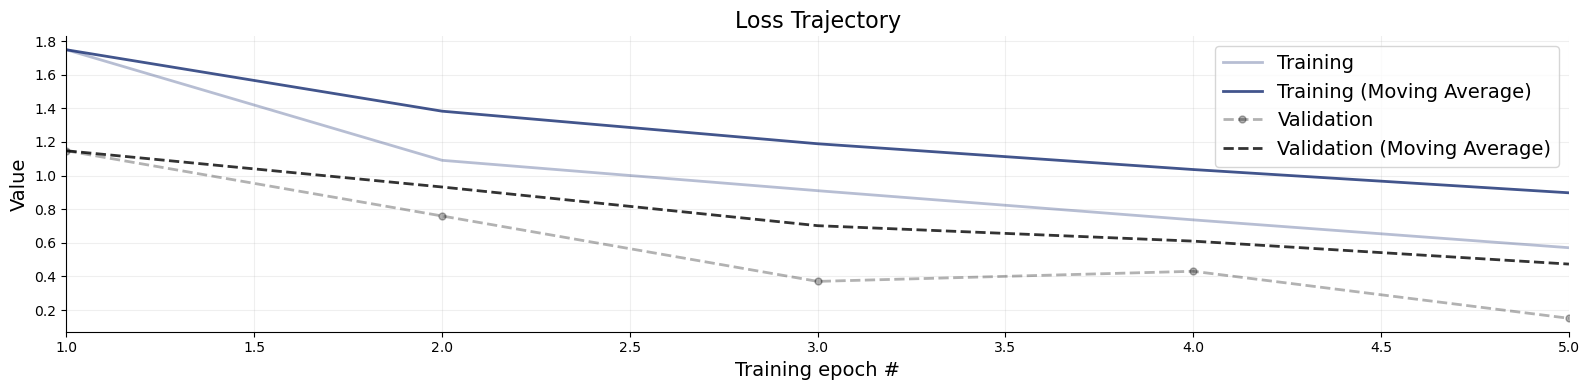

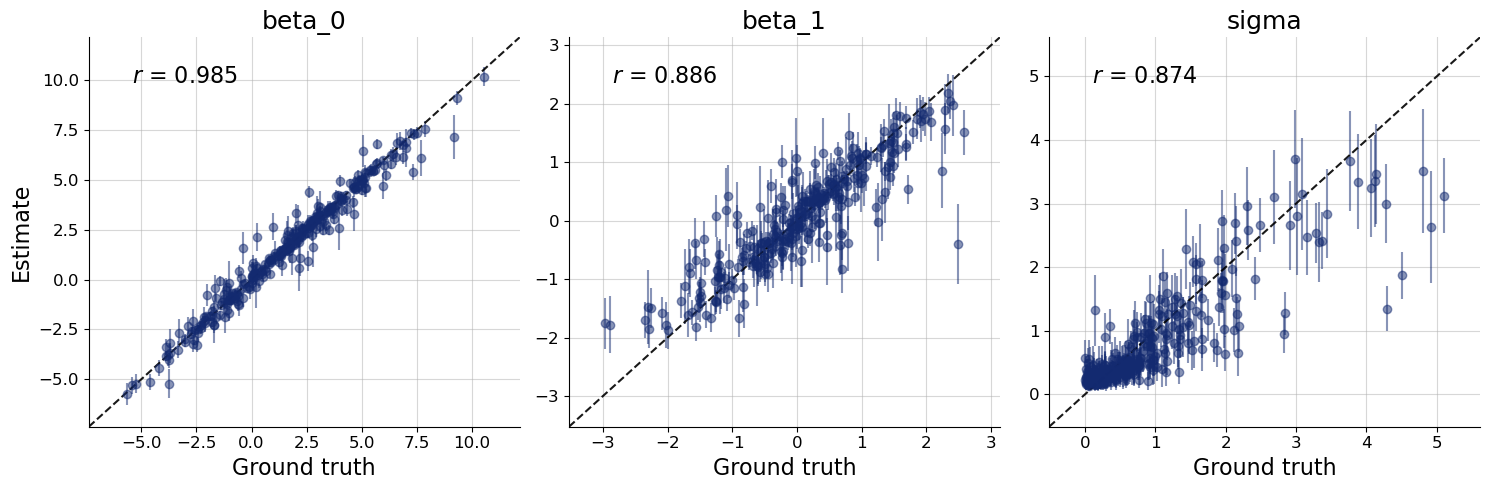

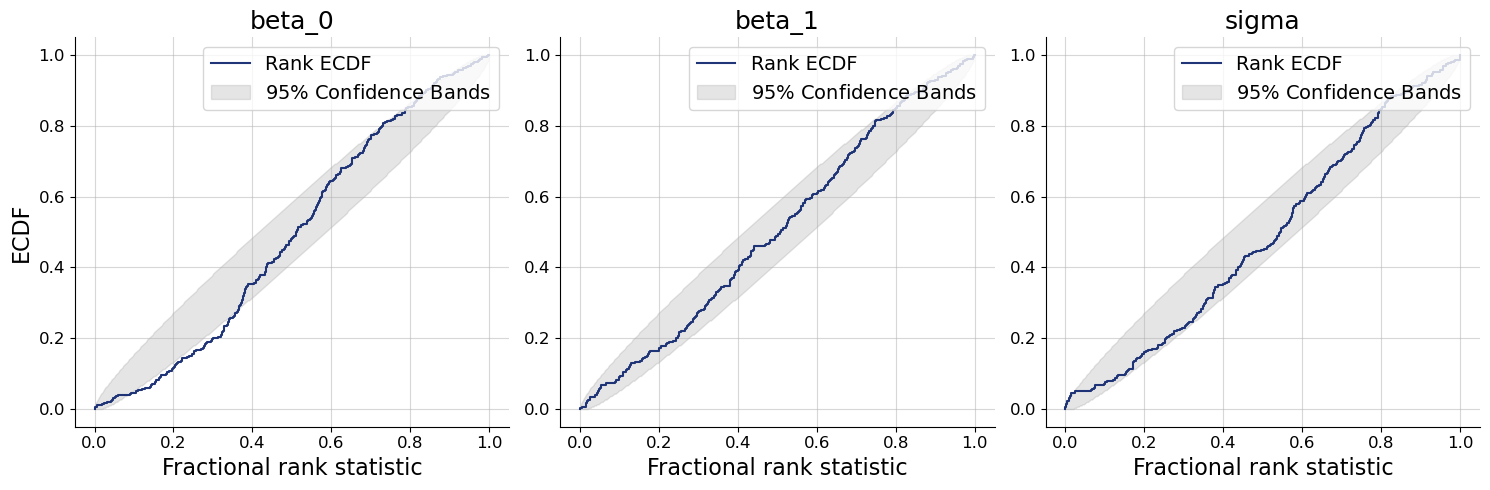

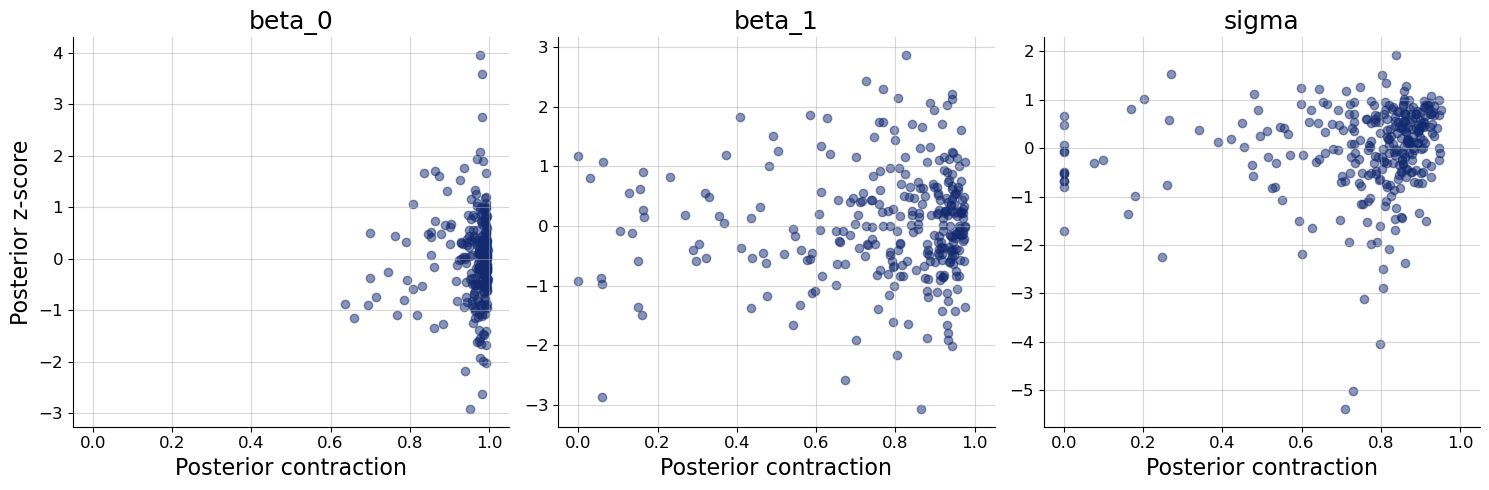

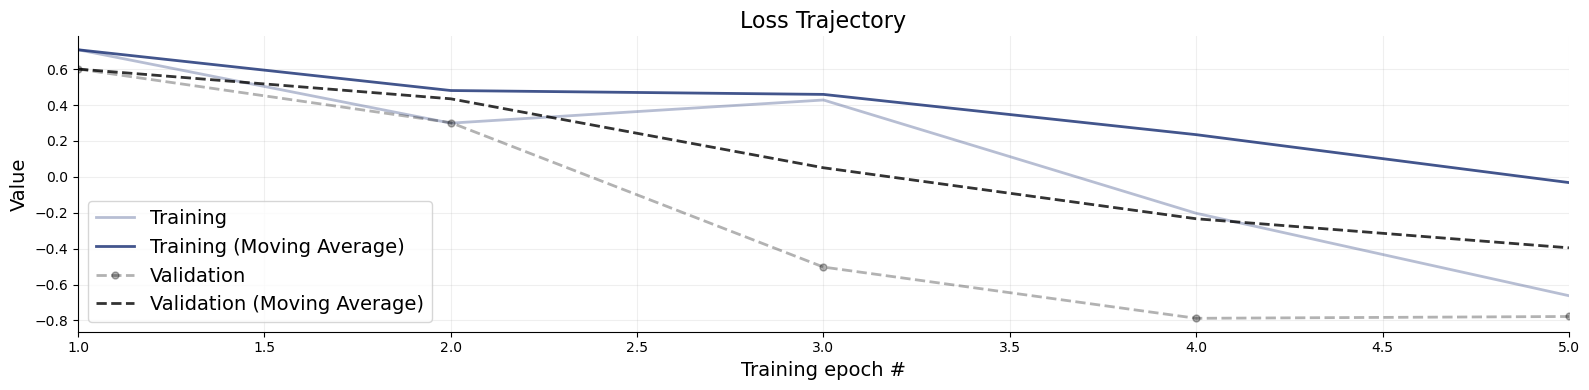

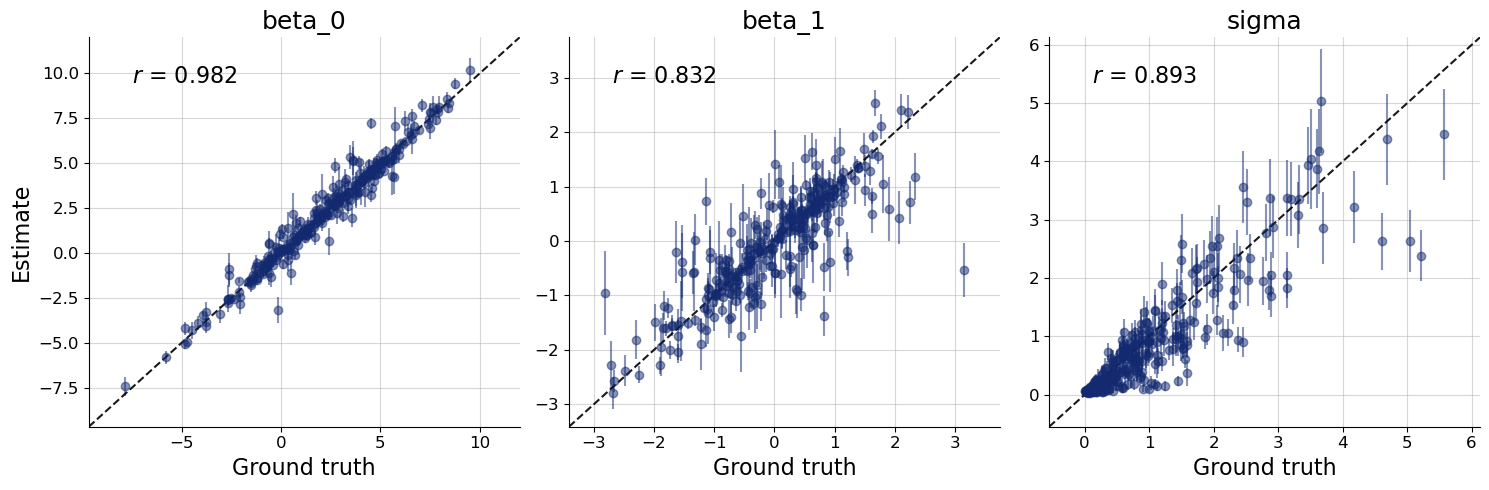

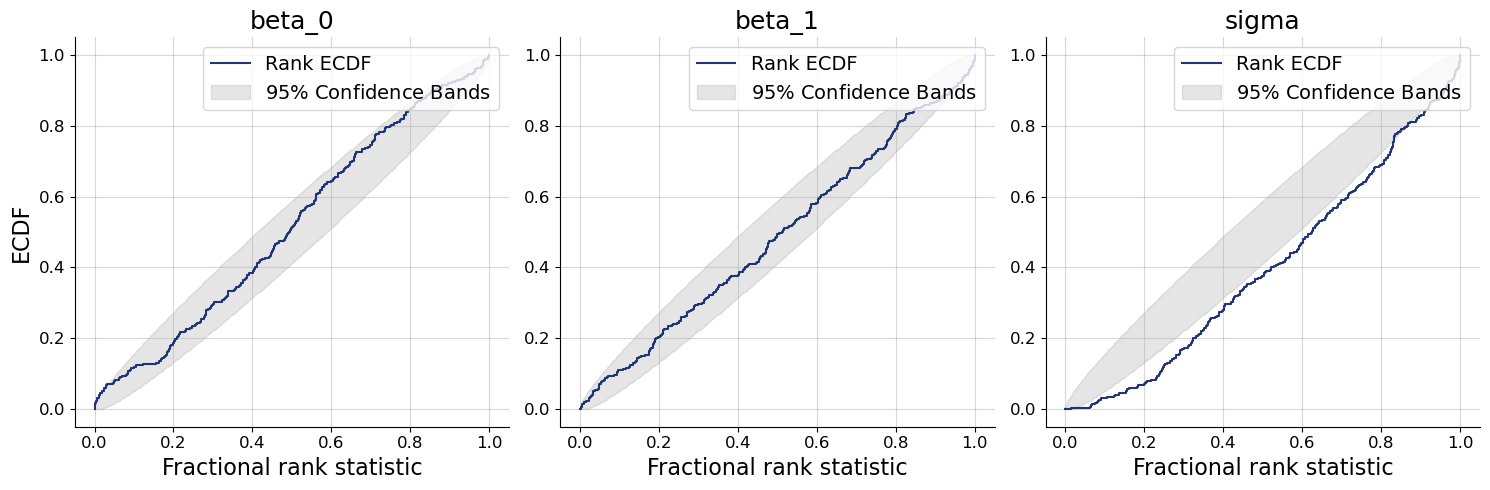

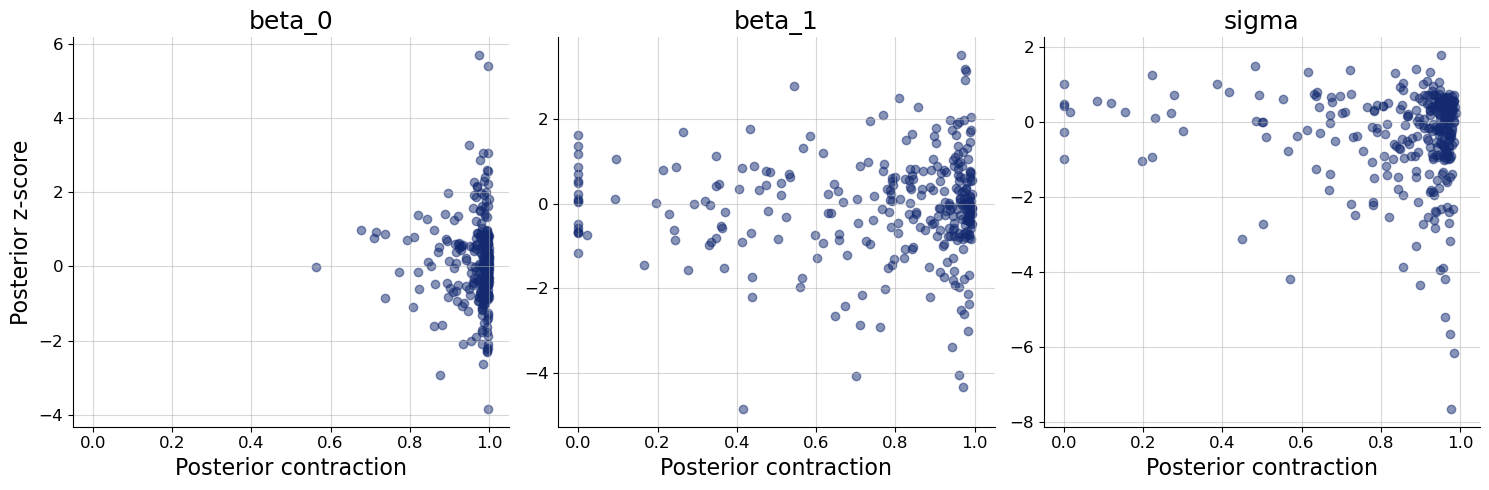

In [3]:
workflows = {}
summary_nets = dict(deepset=bf.networks.DeepSet(summary_dim=10), deepset_old=DeepSetOld(summary_dim=10), settransformer=bf.networks.SetTransformer(summary_dim=10))

for key, summary_network in summary_nets.items():

    inference_network = bf.networks.CouplingFlow()
    #inference_network = bf.networks.PointInferenceNetwork(
    #    scores=dict(mvn=bf.scores.MultivariateNormalScore()),
    #)
    
    workflows[key] = bf.BasicWorkflow(
        simulator=simulator,
        adapter=adapter,
        inference_network=inference_network,
        summary_network=summary_network,
    )
    
    history = workflows[key].fit_online(epochs=50, batch_size=64, num_batches_per_epoch=200, validation_data=val_sims, verbose=2)
    
    diagnostics = workflows[key].plot_default_diagnostics(test_data=300)